# Set up quantum systems
**Building objects that describe your quantum system**

In order to use the Q-CTRL Python package to analyze and improve your quantum system, you must first translate your system into the language used by the Q-CTRL ecosystem. The Q-CTRL Python package uses two different representations of quantum systems:
 - *Graphs*, a general and flexible representation that can be used for any quantum system.
 - *Drives, shifts, and drifts*, a more restrictive representation that forces the relationships between control signals and Hamiltonian terms to be linear.

Our aim is eventually to use graphs for all features, but some features currently still require drives, shifts, and drifts.

In this notebook we demonstrate how to describe quantum systems using both of these representations.

## Imports and initialization

All usage of the Q-CTRL Python package begins by importing the `qctrl` package and starting a session.

In [1]:
import attr
import matplotlib.pyplot as plt
import numpy as np
from qctrlvisualizer import plot_controls

from qctrl import Qctrl

# Starting a session with the API
qctrl = Qctrl()

## Graphs

### Graph-based computation
Several functions in the Q-CTRL Python package make use of *graphs* to represent quantum systems. Graphs use collections of *nodes* and *edges* to represent computations that map inputs to outputs. Formally, these graphs are *directed* and *acyclic*, and are commonly known as [data-flow graphs](https://en.wikipedia.org/wiki/Dataflow_programming), but we refer to them simply as graphs. Each node in a graph describes a primitive computation performed on its input(s), for example the exponential of a number or the multiplication of two matrices. Different nodes are joined by directed edges, which describe how the output of one node is connected to the input of another node. By joining different types of nodes in different ways, you can build graphs representing computations as simple as basic arithmetic through to computations as complex as state propagation in high-dimensional quantum systems. The nodes provided by Q-CTRL are all available in the [`operations`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Operations.html) namespace of the Q-CTRL Python package.

The graph representation offers three key advantages over other approaches to representing generic computations:
 - Flexibility: no particular structure is enforced, so you can represent *any* computation that can be expressed in terms of the provided nodes.
 - Efficiency: graphs can be evaluated extremely efficiently.
 - Automatic differentiation: graphs can be automatically differentiated, enabling features like gradient-based optimization and calculation of Hessian matrices.

Before explaining how graphs are used to represent quantum systems, we give a brief introduction to working with them in the abstract sense.

#### Creating graphs
The first step in creating a graph is to use the `qctrl.create_graph` function to create the Python object representing the graph. Technically this object is a *Python context manager*, which you enter using the `with` keyword. With the graph object created, you can then create graph nodes by calling functions in the `qctrl.operations` namespace. All calls to `qctrl.operations` functions must be made inside the context manager that you created, to ensure that nodes are added to the correct graph. Below we show how to create a simple graph that adds two numbers.

In [21]:
with qctrl.create_graph() as graph:
    result = qctrl.operations.add(1.5, 2.5)

#### Working with graphs
Graphs provide a powerful and efficient framework for performing computations remotely, and have some important differences when compared to libraries like NumPy. You might expect that if we printed the `result` object, we would see a value of `4`. However, this is not the case:

In [22]:
print(result)

TensorNodeData(operation=<qctrlcommons.node.wrapper.Operation object at 0x7f852e714a50>, shape=())


The key point to understand is that the graph itself does not perform the computation; instead it is a *recipe for performing the computation remotely*. You can only get the computed values out of a graph after you have evaluated it, which you will see how to do later in this guide.

For now, we can explore some more consequences of the fact that graphs do not get evaluated immediately. Below, we add a node to the graph that represents an *optimization variable*. You'll see more of optimization variables later, but for now you only need to know that the `qctrl.operations.bounded_optimization_variable` function returns an object representing `count` (in this case 10) values.

In [25]:
with graph:
    variables = qctrl.operations.bounded_optimization_variable(
        count=10,
        lower_bound=0,
        upper_bound=1,
    )
    print(variables)

TensorNodeData(operation=<qctrlcommons.node.wrapper.Operation object at 0x7f852e63d950>, shape=(10,))


As with the addition we performed above, the `variables` object is not an array of numbers, but it is a *representation* of an array of numbers that will be computed in the cloud when you evaluate the graph. We call such an object a *tensor*. You can manipulate tensors in much the same way as NumPy arrays, although you need to use `qctrl.operations` functions instead of NumPy functions. For certain basic arithmetic operations you can also use regular Python syntax, which is a convenient wrapper around the corresponding `qctrl.operations` functions. Finally, when calling a `qctrl.operations` function that accepts tensors, you can usually also pass NumPy arrays.

In [26]:
with graph:
    first_variable = variables[0]
    print(first_variable)

    scaled_variables = variables * 5
    print(scaled_variables)

    added_variables = qctrl.operations.add(scaled_variables, np.linspace(0, 1, 10))
    print(added_variables)

TensorNodeData(operation=<qctrlcommons.node.wrapper.Operation object at 0x7f852f1f35d0>, shape=())
TensorNodeData(operation=<qctrlcommons.node.wrapper.Operation object at 0x7f852e55cf50>, shape=(10,))
TensorNodeData(operation=<qctrlcommons.node.wrapper.Operation object at 0x7f852e55cb50>, shape=(10,))


Tensors are not the only types that live in graphs. Some `qctrl.operations` functions return other types of data too, representing (for example) piecewise-constant functions of time or callable kernel functions. While these other types do not represent simple arrays of numbers, they are still similar to tensors in the sense that they represent the result of a remote computation that will be performed in the cloud. You will see examples of these types later in this guide, and you can also see the [reference documentation](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Operations.html) for more details.

#### Evaluating graphs
There are currently two ways to evaluate graphs:
 - Using [`calculate_graph`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Functions/calculate_graph.html), which simply calculates and returns the values of specific nodes in the graph.
 - Using [`calculate_optimization`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Functions/calculate_optimization.html), which optimizes special *optimization variable* nodes in order to minimize a specified *cost* node, and then returns the values of specific nodes in the graph. All graphs used for optimizations contain at least one of the special optimization variable nodes (and such nodes cannot be used with `calculate_graph`).
 
You will see both of these functions used later in this guide.

### Quantum systems as graphs
The typical purpose of graph objects in the Q-CTRL Python package is to represent quantum systems. The graph representation of such a system can be used to perform several tasks, including [optimal control](https://docs.q-ctrl.com/boulder-opal/user-guides/optimization) (for calculating optimized control pulses), [simulation](https://docs.q-ctrl.com/boulder-opal/user-guides/simulation) (to understand the dynamics of the system in the presence of specific controls and noises), and [system identification](https://docs.q-ctrl.com/boulder-opal/user-guides/optimize-controls#Example-Estimating-system-parameters) (to estimate the values of unknown system parameters based on measurements of the system).

To enable convenient and efficient computations, Q-CTRL offers a wide variety of nodes to help build graphs describing quantum systems, in addition to the standard mathematical operations common to other data-flow programming libraries. As with the basic nodes introduced earlier, the nodes for working with quantum systems are available in the [`operations`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Operations.html) namespace of the Q-CTRL Python package.

Typically you will first create nodes that describe the Hamiltonian of your quantum system. A standard flow is:
 - Create "signals", or scalar-valued functions of time, which may be non-linear, have enforced temporal structure such as time symmetry, or more generally can depend arbitrarily on input parameters.
 - Create "operators", or operator-valued functions of time, by multiplying constant matrices (for example Pauli matrices) by signals.
 - Sum the operators into a single Hamiltonian operator.

From this Hamiltonian you can then add nodes to perform further computations, for example calculating time evolution operators, operational infidelities, or filter function values.

Note that while this approach of constructing Hamiltonians is the most common, it is not a requirement—you can use graphs to perform a wide variety of other computations too. For example, the Q-CTRL Python package also provides specialized functions for working with trapped ions systems that take advantage of certain approximations to bypass Hamiltonian-level descriptions of the system (see the [Mølmer–Sørensen](https://docs.q-ctrl.com/boulder-opal/user-guides/optimizing-molmer-sorensen-gates) User guide for details).

Full descriptions of all the nodes provided by the Q-CTRL Python package are available in the [reference documentation](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Operations.html).

### Worked example: Two-qubit system with a tunable coupling qubit
Consider a system consisting of three transmon qubits, in which the central qubit acts as a tunable coupler between the other two, as proposed by [Yan et al](https://arxiv.org/abs/1803.09813). This system can be approximated by the following two-qubit Hamiltonian:

$$\tilde H = \frac{\omega_a}{2} \sigma_{z, a} +\frac{\omega_b}{2} \sigma_{z, b} + \frac{g_a^2}{2 \Delta_a} \sigma_{z,a}+ \frac{g_b^2}{2 \Delta_b} \sigma_{z,b} +  \tilde g \left(\sigma_{+, a} \sigma_{-,b} + \sigma_{-,a} \sigma_{+,b} \right),$$

where $\omega_k$ are the qubit frequencies, $\Delta_k=\omega_k-\omega_c$ are the detunings of each qubit from the coupling qubit, $g_k$ are the direct couplings between each qubit and the coupling qubit, and $\tilde g$ is the effective coupling between the two qubits. The couplings $g_k,\tilde g$ are given by:

$$ g_k \approx \frac{1}{2}\frac{C_{kc}}{\sqrt{C_kC_c}}\sqrt{\omega_a\omega_c}$$
$$ \tilde g = \frac{1}{2}\left[\frac{\omega_c}{2\Delta}\eta - \frac{\omega_c}{2\Sigma}\eta + \eta + 1\right]\frac{C_{ab}}{\sqrt{C_aC_b}}\sqrt{\omega_a\omega_b},$$

where $\omega_k,\omega_c$ are the frequencies of the qubits, $C_k,C_c$ are the capacitances of the qubits, $C_{xy}$ are the qubit-qubit capacitances between each pair of qubits, and the derived quantities are given by $\eta=C_{ac}C_{bc}/C_{ab}C_c$, $1/\Sigma=(1/\Sigma_a+1/\Sigma_b)/2$, $\Sigma_k=\omega_k+\omega_c$, $1/\Delta=(1/\Delta_a+1/\Delta_b)/2$.

By adjusting the frequency $\omega_c$ of the coupling qubit, the effective coupling strength $\tilde g$ can be tuned.

In this example we show how to represent this system as a graph.

#### Defining system parameters
We first define some basic parameters for the system.

In [2]:
# Standard qubit operators
identity = np.array([[1.0, 0.0], [0.0, 1.0]], dtype=np.complex)
sigma_z = np.array([[1.0, 0.0], [0.0, -1.0]], dtype=np.complex)
sigma_minus = np.array([[0.0, 1.0], [0.0, 0.0]], dtype=np.complex)
iswap = np.array(
    [
        [1.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 1j, 0.0],
        [0.0, 1j, 0.0, 0.0],
        [0.0, 0.0, 0.0, 1.0],
    ],
    dtype=np.complex,
)

# 2-qubit operators
sigma_z_a = np.kron(sigma_z, identity)
sigma_z_b = np.kron(identity, sigma_z)
sigma_plus_minus = np.kron(sigma_minus.T, sigma_minus)

# Physical parameters
C_a = 70  # fF
C_b = 72  # fF
C_ac = 4  # fF
C_bc = 4.2  # fF
C_c = 200  # fF
C_ab = 0.1  # fF
omega_a = 2 * np.pi * 4e9  # Hz
omega_b = 2 * np.pi * 4e9  # Hz
eta = C_ac * C_bc / (C_ab * C_c)
gate_duration = 100e-9  # s

#### Building the Hamiltonian
Below we define a function that creates a graph object for the Hamiltonian of the tunable coupler system. The inputs to the function are the parameters that we want to vary (which could be for many purposes, for example optimizable parameters in optimal control, input parameters for simulation, or unknown parameters for system identification). In this case, we pass a tensor of values for the coupling frequency $\omega_c$, and the function will produce a corresponding tensor of output values for the Hamiltonian. Recall that a tensor simply refers to a multi-dimensional array of real or complex numbers that will be calculated remotely when you evaluate the graph. 

In order to explain each step, we break the function into several parts. In your own code, it would be simpler to merge these functions into one.

##### Creating derived quantities
As described earlier, you create graph nodes by calling functions in the `qctrl.operations` namespace. For basic arithmetic (for example addition and multiplication), you can also use standard Python syntax, which is a convenient short-hand for the corresponding `qctrl.operations` functions. Below we show how to use these features to define derived quantities that depend on $\omega_c$.

In [3]:
def derived_quantities(omega_c):
    Delta_a = omega_a - omega_c
    Delta_b = omega_b - omega_c
    Delta = 2 / (1 / Delta_a + 1 / Delta_b)
    Sigma_a = omega_a + omega_c
    Sigma_b = omega_b + omega_c
    Sigma = 2 / (1 / Sigma_a + 1 / Sigma_b)

    g_a = 0.5 * C_ac * qctrl.operations.sqrt(omega_a * omega_c / (C_a * C_c))
    g_b = 0.5 * C_bc * qctrl.operations.sqrt(omega_b * omega_c / (C_b * C_c))
    g_tilde = (
        0.5
        * (omega_c * eta / (2 * Delta) - omega_c * eta / (2 * Sigma) + eta + 1)
        * C_ab
        * qctrl.operations.sqrt(omega_a * omega_b / (C_a * C_b))
    )

    return g_a, g_b, g_tilde, Delta_a, Delta_b

##### Creating signals
The Q-CTRL Python package provides nodes that make it convenient to describe Hamiltonians. To use these, you can first convert the derived quantities into *signals*, which represent functions of time appearing in the Hamiltonian. See the [reference documentation](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Operations/pwc_signal.html) for the `pwc_signal` function for the mathematical details of exactly how a 1D tensor of values is converted into a piecewise-constant (PWC) function of time.

In [4]:
def signals(omega_c):
    g_a, g_b, g_tilde, Delta_a, Delta_b = derived_quantities(omega_c)

    detuning_a = qctrl.operations.pwc_signal(
        values=g_a ** 2 / (2 * Delta_a), duration=gate_duration
    )
    detuning_b = qctrl.operations.pwc_signal(
        values=g_b ** 2 / (2 * Delta_b), duration=gate_duration
    )
    coupling = qctrl.operations.pwc_signal(values=g_tilde, duration=gate_duration)

    return detuning_a, detuning_b, coupling

##### Creating operators
With the signals created, you can combine them with constant matrices to create *operators*, which represent PWC operator-valued functions of time. Usually these operators represent individual terms in your Hamiltonian. You can also create constant operators, representing static terms in your Hamiltonian—in this case the fixed frequency terms for each qubit.

In [5]:
def operators(omega_c):
    detuning_a, detuning_b, coupling = signals(omega_c)

    detuning_a_term = qctrl.operations.pwc_operator(
        signal=detuning_a, operator=sigma_z_a
    )
    detuning_b_term = qctrl.operations.pwc_operator(
        signal=detuning_b, operator=sigma_z_b
    )
    coupling_term = qctrl.operations.pwc_operator(
        signal=coupling, operator=sigma_plus_minus + sigma_plus_minus.T
    )

    fixed_frequency_a_term = qctrl.operations.constant_pwc_operator(
        operator=omega_a * sigma_z_a / 2, duration=gate_duration
    )
    fixed_frequency_b_term = qctrl.operations.constant_pwc_operator(
        operator=omega_b * sigma_z_b / 2, duration=gate_duration
    )

    return (
        detuning_a_term,
        detuning_b_term,
        coupling_term,
        fixed_frequency_a_term,
        fixed_frequency_b_term,
    )

##### Combining operators
You can easily sum multiple operators, to yield the overall system Hamiltonian.

In [6]:
def hamiltonian(omega_c):
    (
        detuning_a_term,
        detuning_b_term,
        coupling_term,
        fixed_frequency_a_term,
        fixed_frequency_b_term,
    ) = operators(omega_c)

    hamiltonian = qctrl.operations.pwc_sum(
        [
            detuning_a_term,
            detuning_b_term,
            coupling_term,
            fixed_frequency_a_term,
            fixed_frequency_b_term,
        ]
    )

    return hamiltonian

#### Building a graph for a specific computation
The `hamiltonian` function defined above creates a graph object representing the Hamiltonian of the system. In order to do computations (for example simulations or optimizations), you embed this graph inside a larger graph that represents the overall computation. Below we show how this procedure works for a simulation.

##### Creating the graph object
The first step is to use the `qctrl.create_graph` function to create the Python object representing the graph. This graph will contain all the nodes we create when describing the quantum system.

In [7]:
graph = qctrl.create_graph()

##### Creating the Hamiltonian from the input values
The first part of the graph sets up the necessary inputs to the Hamiltonian. For an optimization, these inputs typically depend on optimizable variables. For a simulation, the inputs can be known values for control pulses, or  quantities derived from known values.

In this case we demonstrate the latter. We consider a simple piecewise-constant pulse for $\omega_c$ which is then passed through imperfect control lines. The effect of these control lines is to distort the signal that actually reaches the system. We use the values from this distorted signal as the input to the Hamiltonian. See the [Optimization](https://docs.q-ctrl.com/boulder-opal/user-guides/optimization) User guide for more details about incorporating filters into your graphs.

Note that any value produced from a node can be given a name, to make it easier to extract its value after the computation has been performed. In this case we give names to the raw and filtered signals, so that we can later visualize the effect of the control lines.

In [8]:
with graph:
    # Create basic piecewise-constant signal
    omega_c_raw_values = (
        (5.4 - 0.34 * np.array([0, 1, 2, 3, 2, 1, 0])) * 2 * np.pi * 1e9
    )  # Hz
    omega_c_raw = qctrl.operations.pwc_signal(
        duration=gate_duration,
        values=omega_c_raw_values,
        name="omega_c_raw",
    )

    # Apply a sinc filter to simulate the effect of control line imperfections
    omega_c_smooth = qctrl.operations.convolve_pwc(
        pwc=omega_c_raw,
        kernel_integral=qctrl.operations.sinc_integral_function(2 * np.pi * 0.1e9),
    )

    # Discretize the resulting smooth signal to obtain a finely-sampled
    # piecewise-constant approximation
    omega_c_filtered = qctrl.operations.discretize_stf(
        stf=omega_c_smooth,
        duration=gate_duration,
        segments_count=100,
        name="omega_c_filtered",
    )

    # Create the Hamiltonian using the filtered signal as the input
    h = hamiltonian(omega_c_filtered.values)

##### Creating derived properties
The Q-CTRL Python package provides several functions for deriving properties of quantum systems from Hamiltonians. In this case we calculate the time evolution operators for the system (see the [Simulation](https://docs.q-ctrl.com/boulder-opal/user-guides/simulation) User guide for more details).

In [9]:
with graph:
    time_evolution_operators = qctrl.operations.time_evolution_operators_pwc(
        hamiltonian=h,
        sample_times=np.linspace(0, gate_duration, 10),
        name="time_evolution_operators",
    )

#### Calling a function with the graph
The graph we have constructed represents both the quantum system and the desired computation on that quantum system. In this case the computation is a simple simulation, but you can create similar graphs for both optimization and system identification (see the [Optimization](https://docs.q-ctrl.com/boulder-opal/user-guides/optimization) User guide for examples). To run the simulation, we use the [`calculate_graph`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Functions/calculate_graph.html) function, which evaluates the time evolution operators for the system as well as the raw and filtered input signals that we defined earlier (and, more generally, can be used to calculate the values of any named nodes in the graph).

In [10]:
result = qctrl.functions.calculate_graph(
    graph=graph,
    output_node_names=["time_evolution_operators", "omega_c_raw", "omega_c_filtered"],
)

100%|██████████| 100/100 [00:03<00:00, 29.55it/s]


#### Extracting the results
The evaluated values can be extracted from the `result` object. The specific form of outputs is discussed in detail in the more specific user guides, so here we simply display a visualization of the raw and filtered input signals (using the Q-CTRL Python Visualizer package), and print the final time evolution operator. We see that the chosen controls produce a gate that is, up to single-qubit phases, close to an iSWAP.

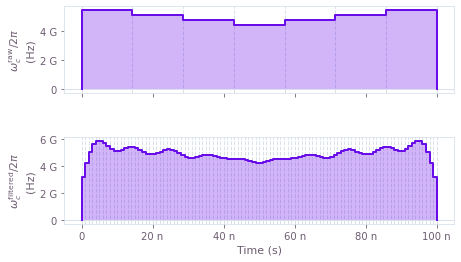

Final time evolution operator:
[[-0.126-0.992j  0.   +0.j     0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j    -0.169-0.058j -0.   +0.984j  0.   +0.j   ]
 [ 0.   +0.j     0.   +0.984j -0.169+0.058j  0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j     0.   +0.j    -0.126+0.992j]]


In [11]:
plot_controls(
    plt.figure(),
    {
        "$\omega_c^\\mathrm{raw}$": result.output["omega_c_raw"],
        "$\omega_c^\\mathrm{filtered}$": result.output["omega_c_filtered"],
    },
)
plt.show()

print("Final time evolution operator:")
print(np.round(result.output["time_evolution_operators"]["value"][-1], 3))

#### Summary
We have shown the general procedure for describing a quantum system, and a computation performed on that quantum system, as a graph object. The approach we have used here—of defining the Hamiltonian inside a function and then plugging this function into the graph creation—is simple and powerful, but not the only possible approach. For example, for simple systems you might find it easier to define your entire graph within a single block, while for for complex systems it might be helpful to split creation of the graph across several different functions. You can visit the other [User guides](https://docs.q-ctrl.com/boulder-opal/user-guides/) and [Application notes](https://docs.q-ctrl.com/boulder-opal/application-notes/) to see several more approaches to using graphs for describing different types of systems and solving different types of problems, and the [reference documentation](https://docs.q-ctrl.com/boulder-opal/references/qctrl) to see more details about all functions and types in the Q-CTRL Python package.

### Example: One-qubit system for an optimization

Next we present a full example of a simple one-qubit system set up for optimization. We consider the Hamiltonian:

\begin{align*}
H(t) = & \frac{\nu}{2} \sigma_z + \frac{\Omega(t)}{2} \sigma_- + \frac{\Omega^*(t)}{2} \sigma_+ + \frac{\Delta(t)}{2} \sigma_z,
\end{align*}

where $\nu$ is the qubit detuning, $\Omega(t)$ is a time-dependent Rabi rate, $\Delta(t)$ is a time-dependent clock shift, and $\sigma_k$ are the Pauli matrices.

We will use optimization to find controls $\Omega(t)$ and $\Delta(t)$ that produce a NOT gate. As above, we use a graph to represent the computation. This time, the inputs to the Hamiltonian are *optimization variables*, that represent quantities that can be controlled and optimized. Once the Hamiltonian is constructed, it is used as the input to an *infidelity* node, which represents the cost function minimized by the optimizer in order to find the optimal controls. See the [Optimization](https://docs.q-ctrl.com/boulder-opal/user-guides/optimization/) User guide for details and more examples.

100%|██████████| 100/100 [00:03<00:00, 30.40it/s]


Infidelity:
3.5464964298626e-12


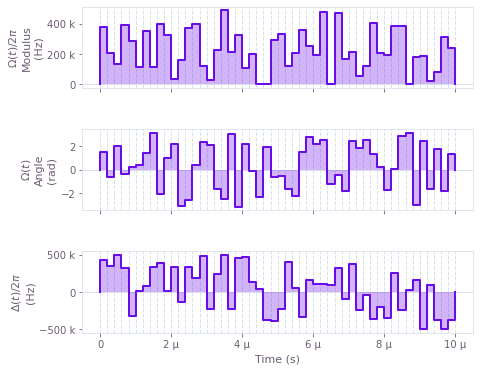

In [12]:
# Define standard matrices
sigma_x = np.array([[0, 1], [1, 0]])
sigma_z = np.array([[1, 0], [0, -1]])
sigma_m = np.array([[0, 1], [0, 0]])

# Define physical constants
nu = 2 * np.pi * 0.5 * 1e6  # Hz
omega_max = 2 * np.pi * 0.5e6  # Hz
delta_max = 2 * np.pi * 0.5e6  # Hz
segment_count = 50
duration = 10e-6  # s

# Create the graph describing the system
with qctrl.create_graph() as graph:
    # Create the optimizable variables for the controls

    omega_moduli = qctrl.operations.bounded_optimization_variable(
        count=segment_count,
        lower_bound=0,
        upper_bound=omega_max,
    )
    omega_phases = qctrl.operations.unbounded_optimization_variable(
        count=segment_count,
        initial_lower_bound=0,
        initial_upper_bound=2 * np.pi,
    )
    delta_values = qctrl.operations.bounded_optimization_variable(
        count=segment_count,
        lower_bound=-delta_max,
        upper_bound=delta_max,
    )

    # Create the Hamiltonian

    # Create the signals
    omega = qctrl.operations.complex_pwc_signal(
        moduli=omega_moduli,
        phases=omega_phases,
        duration=duration,
        name="omega",
    )
    delta = qctrl.operations.pwc_signal(
        values=delta_values,
        duration=duration,
        name="delta",
    )

    # Create the operators
    detuning = qctrl.operations.constant_pwc_operator(
        operator=nu * sigma_z / 2,
        duration=duration,
    )
    drive = qctrl.operations.pwc_operator_hermitian_part(
        qctrl.operations.pwc_operator(signal=omega, operator=sigma_m)
    )
    clock = qctrl.operations.pwc_operator(signal=delta, operator=sigma_z / 2)

    # Sum the operators
    hamiltonian = qctrl.operations.pwc_sum(
        [
            detuning,
            drive,
            clock,
        ]
    )

    # Calculate the infidelity, derived from the Hamiltonian

    infidelity = qctrl.operations.infidelity_pwc(
        hamiltonian=hamiltonian,
        target_operator=qctrl.operations.target(sigma_x),
        name="infidelity",
    )

# Call the function
result = qctrl.functions.calculate_optimization(
    graph=graph,
    cost_node_name="infidelity",
    output_node_names=["omega", "delta"],
    optimization_count=1,
)

# Visualize the results
plot_controls(
    plt.figure(),
    {"$\Omega(t)$": result.output["omega"], "$\Delta(t)$": result.output["delta"]},
)

print("Infidelity:")
print(result.cost)

### Example: Mølmer–Sørensen system for an optimization

Next we present a full example of an ion chain system under a Mølmer–Sørensen interaction set up for optimization. The Hamiltonian of such a system is:

$$ H(t) = i\frac{\hbar}{2} \sum_{j=1}^N \sigma_{x, j} \sum_{p=1}^{3N} \eta_{pj} \left( 
        \gamma_{j}(t) a_{p}^\dagger - \gamma^\ast_{j}(t) a_p \right),
$$
where $N$ is the number of ions, $\sigma_x$ is the Pauli $X$ operator, $a_p$ is the annihilation operator for the mode $p$, $\eta_{pj}$ is the Lamb–Dicke parameter of mode $p$ for the ion $j$, and $\gamma_j(t)$ is the drive applied ion the ion $j$.

Unlike the examples above, where we first modeled the Hamiltonian and then calculated the dynamics of the system based on the Hamiltonian, for an ion chain system we can use built-in nodes to calculate the dynamics of the system directly. Using information about the properties of the ions and the drive fields, the [`ms_phases`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Operations/ms_phases.html) and [`ms_displacements`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Operations/ms_displacements.html) nodes compute, respectively, the relative phases for all ion pairs and the phase space displacements of the collective modes of motion. The [`ms_infidelity`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Operations/ms_infidelity.html) node can then be used to calculate the infidelity of the realized system dynamics relative to a target gate (characterized by zero residual displacement and relative phases matching specified target values).

In this example we consider a chain of two ${}^{171}{\rm Yb}^{+}$ ions, with the goal of finding a pair of drives that produce zero residual displacement and a relative phase of $\pi/4$. You can visit the [Optimizing Mølmer–Sørensen gates](https://docs.q-ctrl.com/boulder-opal/user-guides/optimizing-molmer-sorensen-gates) user guide for more details and examples, including information about how to calculate the ion chain properties that we hardcode in this example.

100%|██████████| 100/100 [00:03<00:00, 31.91it/s]


Infidelity:
1.727917808835855e-10


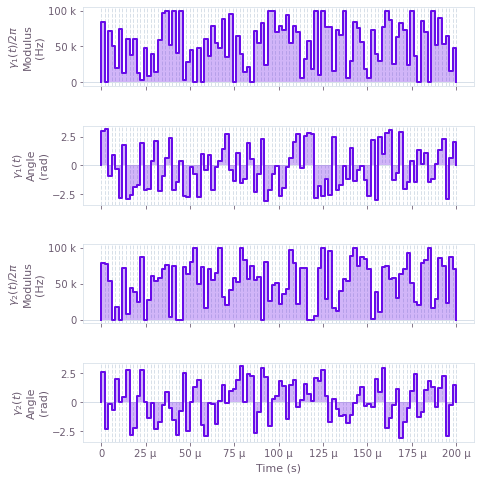

In [13]:
# Define ion chain properties
relative_detunings = np.array(
    [
        [-33076.63544983, -4700.0],
        [-135006.15433009, -104700.0],
        [-1304700.0, -1085084.75772933],
    ],
)
lamb_dicke_parameters = np.array(
    [
        [[-0.05519423, 0.05519423], [0.0547026, 0.0547026]],
        [[-0.05707613, 0.05707613], [0.0564966, 0.0564966]],
        [[0.0, 0.0], [0.0, 0.0]],
    ],
)

# Define physical constants
gamma_max = 2 * np.pi * 100e3  # Hz
segment_count = 100
duration = 2e-4  # s

# Define target phases as a lower triangular matrix
target_phases = np.array([[0, 0], [np.pi / 4, 0]])

# Create the graph describing the system
with qctrl.create_graph() as graph:
    # Create the drive signals based on optimizable variables
    drives = [
        qctrl.operations.complex_pwc_signal(
            moduli=qctrl.operations.bounded_optimization_variable(
                count=segment_count, lower_bound=0, upper_bound=gamma_max
            ),
            phases=qctrl.operations.unbounded_optimization_variable(
                count=segment_count,
                initial_lower_bound=0,
                initial_upper_bound=2 * np.pi,
            ),
            duration=duration,
        )
        for _ in range(2)
    ]

    # Calculate the system dynamics (relative phases and displacements),
    # derived from the drive signals
    relative_phases = qctrl.operations.ms_phases(
        drives=drives,
        lamb_dicke_parameters=lamb_dicke_parameters,
        relative_detunings=relative_detunings,
    )
    displacements = qctrl.operations.ms_displacements(
        drives=drives,
        lamb_dicke_parameters=lamb_dicke_parameters,
        relative_detunings=relative_detunings,
    )

    # Calculate the infidelity
    infidelity = qctrl.operations.ms_infidelity(
        phases=relative_phases,
        displacements=displacements,
        target_phases=target_phases,
        name="infidelity",
    )

# Call the function
result = qctrl.functions.calculate_optimization(
    cost_node_name="infidelity",
    output_node_names=[drives[0].name, drives[1].name],
    graph=graph,
    optimization_count=1,
)

# Visualize the results
plot_controls(
    plt.figure(),
    {
        "$\gamma_1(t)$": result.output[drives[0].name],
        "$\gamma_2(t)$": result.output[drives[1].name],
    },
)

print("Infidelity:")
print(result.cost)

## Drives, shifts, and drifts
Some functions use a simpler, but less flexible, representation than graphs for describing quantum systems. Specifically, we consider Hamiltonians that can be decomposed into a sum of *drive*, *shift*, and *drift* terms. A drive term is a constant non-Hermitian operator multiplied by a complex scalar-valued function of time, plus its Hermitian conjugate. A shift term is a constant Hermitian operator multiplied by a real scalar-valued function of time. A drift term is a constant Hermitian operator. We can write such a Hamiltonian in the form

\begin{align*}
H(t) = \sum_{j=1}^{N_\mathrm{drives}} \left(\gamma_j(t)C_j + \mathrm{H.c}\right)
     + \sum_{k=1}^{N_\mathrm{shifts}} \alpha_k(t)A_k
     + \sum_{l=1}^{N_\mathrm{drifts}} D_l,
\end{align*}
where $\gamma_j(t)$ are the complex scalar-valued functions of time modulating the non-Hermitian drive operators $C_j$, $\alpha_k(t)$ are the real scalar-valued functions of time modulating the Hermitian shift operators $A_k$, and $D_l$ are the static Hermitian drift operators.

In order to describe noise processes, each drive, shift, and drift term can also have an associated noise amplitude. Noise on drive and shift terms is used to represent *amplitude noise*, which is relative noise on the modulations $\gamma_j(t)$ or $\alpha_k(t)$ (corresponding to laser intensity fluctuations, for example). Noise on drift terms is used to represent *additive noise*, which is noise that directly modulates the drift operators $D_l$ (corresponding to dephasing noise, for example). Formally, when noises are included the Hamiltonian can be written

\begin{align*}
H(t) =& \sum_{j=1}^{N_\mathrm{drives}} \left(1+\beta_{\gamma_j}(t)\right)\left(\gamma_j(t)C_j + \mathrm{H.c}\right)
     + \sum_{k=1}^{N_\mathrm{shifts}} \left(1+\beta_{\alpha_k}(t)\right)\alpha_k(t)A_k \\
     &+ \sum_{l=1}^{N^\mathrm{(noiseless)}_\mathrm{drifts}} D_l 
     + \sum_{l=1}^{N^\mathrm{(noisy)}_\mathrm{drifts}} \beta_{D_l}(t) D_l,
\end{align*}
where $\beta_x(t)$ are noise amplitudes. Different functions support different forms for the noise amplitudes.

### Worked example: Two-qubit system for a filter function calculation

Consider a two-qubit system represented by the following Hamiltonian:

\begin{align*}
H(t) = & \frac{\nu_a}{2} \sigma_{z,a} + \frac{\nu_b}{2} \sigma_{z,b} + \frac{\Omega_a(t)}{2} \sigma_{-,a} + \frac{\Omega^*_a(t)}{2} \sigma_{+,a} + \frac{\Omega_b(t)}{2} \sigma_{-,b} + \frac{\Omega^*_b(t)}{2} \sigma_{+,b}\\
& + \frac{\Lambda(t)}{2} \sigma_{-,a} \sigma_{+,b} + \frac{\Lambda^*(t)}{2} \sigma_{+,a} \sigma_{-,b} + \frac{\Delta_a(t)}{2} \sigma_{z,a} + \frac{\Delta_b(t)}{2} \sigma_{z,b} + \eta_a(t) \sigma_{z,a} + \eta_b(t)\sigma_{z,b},
\end{align*}

where $\nu_k$ are the qubit detunings, $\Omega_k(t)$ are time-dependent Rabi rates (for example created by a microwave drive), $\Lambda(t)$ is a time-dependent coupling between the qubits, $\Delta_k(t)$ are time-dependent clock shifts, $\eta_k(t)$ are small, slowly-varying, stochastic dephasing noise processes and $\sigma_{\{+,-,z\}, k}$ are the Pauli matrices.

We consider custom pulses defined by the piecewise-constant functions:

\begin{align*}
\Omega_a(t) &= \begin{cases}
                   2\pi\times 1.5e^{0.5\pi i}\times 10^{6}  & 0\leq t\leq 2\times 10^{-6}\\
                   0                                        & 2\times 10^{-6}\leq t\leq 4\times 10^{-6}\\
                   2\pi\times 0.5e^{-0.5\pi i}\times 10^{6} & 4\times10^{-6}\leq t\leq 6\times 10^{-6}
               \end{cases}\\
\Omega_b(t) &= \begin{cases}
                   2\pi\times 1.0e^{0.25\pi i}\times 10^{6} & 0\leq t\leq 2\times 10^{-6}\\
                   0                                        & 2\times 10^{-6}\leq t\leq 4\times 10^{-6}\\
                   2\pi\times 0.5e^{1.25\pi i}\times 10^{6} & 4\times10^{-6}\leq t\leq 6\times 10^{-6}
               \end{cases}\\
\Lambda(t) &=  \begin{cases}
                   0                                        & 0\leq t\leq 2\times 10^{-6}\\
                   2\pi\times 1.0e^{\pi i}\times 10^{6}     & 2\times 10^{-6}\leq t\leq 4\times 10^{-6}\\
                   0                                        & 4\times10^{-6}\leq t\leq 6\times 10^{-6}
               \end{cases}\\
\Delta_a(t) &= \begin{cases}
                   2\pi\times 10.0\times 10^{6}             & 0\leq t\leq 2\times 10^{-6}\\
                   0                                        & 2\times 10^{-6}\leq t\leq 4\times 10^{-6}\\
                   2\pi\times -10.0\times 10^{6}            & 4\times10^{-6}\leq t\leq 6\times 10^{-6}
               \end{cases}\\
\Delta_b(t) &= \begin{cases}
                   2\pi\times -1.0\times 10^{6}             & 0\leq t\leq 2\times 10^{-6}\\
                   0                                        & 2\times 10^{-6}\leq t\leq 4\times 10^{-6}\\
                   2\pi\times 1.5\times 10^{6}              & 4\times10^{-6}\leq t\leq 6\times 10^{-6}
               \end{cases}
\end{align*}

Such a setup would be useful for performing simulation or characterizing susceptibility to noise via filter functions. In this case we create Python objects suitable for calculating a filter function, but the same procedure applies to other computations too.

#### Decomposing the quantum Hamiltonian into drives, shifts, and drifts
For functions that use the drives, shifts, and drifts representation of quantum systems, the first step in analyzing your system is to split the Hamiltonian of your quantum system into the appropriate set of drives, shifts, and drifts. In this case, the Hamiltonian is represented by eight terms:
* a `drift` term with `operator` $\nu_a \sigma_{z,a}/2 + \nu_b \sigma_{z,b}/2$,
* a `drive` term with `operator` $\sigma_{-,a}/2$ and complex `control` $\Omega_a(t)$,
* a `drive` term with `operator` $\sigma_{-,b}/2$ and complex `control` $\Omega_b(t)$,
* a `drive` term with `operator` $\sigma_{-,a} \sigma_{+,b}/2$ and complex `control` $\Lambda(t)$,
* a `shift` term with `operator` $\sigma_{z,a}/2$ and real `control` $\Delta_a(t)$,
* a `shift` term with `operator` $\sigma_{z,b}/2$ and real `control` $\Delta_b(t)$,
* a `drift` term with `operator` $\sigma_{z,a}$ and `noise` amplitude $\eta_a(t)$,
* a `drift` term with `operator` $\sigma_{z,b}$ and `noise` amplitude $\eta_b(t)$.

With this decomposition in hand, we may proceed to set up the appropriate Python objects.

#### Creating the control pulses

Each drive and shift control term in your system must have an associated control pulse, which describes the piecewise-constant scalar-valued function of time that modulates the control operator. A piecewise-constant function of time is represented as a list of segment objects, each describing the duration and value of a constant segment of the function. The function is obtained by concatenating these segments in time. The [`qctrl.types.RealSegmentInput`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Types/RealSegmentInput.html) and [`qctrl.types.ComplexSegmentInput`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Types/ComplexSegmentInput.html) objects represent such segments for real and complex piecewise-constant functions of time, respectively.

In [14]:
# Define physical constants
segment_duration = 1 * 1e-6  # s

# Define control pulses
drive_A_control = [
    qctrl.types.ComplexSegmentInput(
        duration=segment_duration,
        value=2 * np.pi * 1.5 * np.exp(0.5j * np.pi) * 1e6,
    ),
    qctrl.types.ComplexSegmentInput(duration=segment_duration, value=0),
    qctrl.types.ComplexSegmentInput(
        duration=segment_duration,
        value=2 * np.pi * 0.5 * np.exp(-0.5 * np.pi) * 1e6,
    ),
]

drive_B_control = [
    qctrl.types.ComplexSegmentInput(
        duration=segment_duration,
        value=2 * np.pi * 1.0 * np.exp(0.25j * np.pi) * 1e6,
    ),
    qctrl.types.ComplexSegmentInput(duration=segment_duration, value=0),
    qctrl.types.ComplexSegmentInput(
        duration=segment_duration,
        value=2 * np.pi * 1.0 * np.exp(1.25j * np.pi) * 1e6,
    ),
]

coupling_control = [
    qctrl.types.ComplexSegmentInput(duration=segment_duration, value=0),
    qctrl.types.ComplexSegmentInput(
        duration=segment_duration,
        value=2 * np.pi * 1.0 * np.exp(1.0j * np.pi) * 1e6,
    ),
    qctrl.types.ComplexSegmentInput(duration=segment_duration, value=0),
]

clock_A_control = [
    qctrl.types.RealSegmentInput(
        duration=segment_duration,
        value=2 * np.pi * 10.0 * 1e6,
    ),
    qctrl.types.RealSegmentInput(duration=segment_duration, value=0),
    qctrl.types.RealSegmentInput(
        duration=segment_duration,
        value=2 * np.pi * -10.0 * 1e6,
    ),
]

clock_B_control = [
    qctrl.types.RealSegmentInput(
        duration=segment_duration,
        value=2 * np.pi * -1.0 * 1e6,
    ),
    qctrl.types.RealSegmentInput(duration=segment_duration, value=0),
    qctrl.types.RealSegmentInput(
        duration=segment_duration,
        value=2 * np.pi * 1.5 * 1e6,
    ),
]

#### Visualizing the control terms

The piecewise-constant control terms can be visualized using the Q-CTRL Python Visualizer package, as shown below. Also note that the Python objects can be conveniently converted into dictionaries using the `attr.asdict` function.

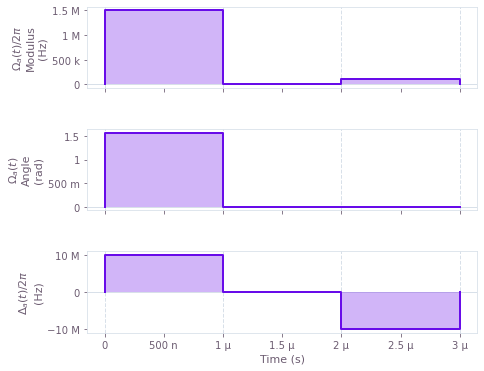

In [15]:
plot_controls(
    plt.figure(),
    {
        "$\Omega_a(t)$": map(attr.asdict, drive_A_control),
        "$\Delta_a(t)$": map(attr.asdict, clock_A_control),
    },
)

#### Creating the control terms

Each control term in your quantum system is represented as a Python object specific to the type of computation you are performing. In the case of filter functions, the relevant objects are [`qctrl.types.filter_function.Drive`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Types/filter_function/Drive.html), [`qctrl.types.filter_function.Shift`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Types/filter_function/Shift.html), and [`qctrl.types.filter_function.Drift`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Types/filter_function/Drift.html). These objects wrap an operator and, in the case of drives and shifts, a control.

In [16]:
# Define standard matrices
identity = np.array([[1.0, 0.0], [0.0, 1.0]], dtype=np.complex)
sigma_z = np.array([[1.0, 0.0], [0.0, -1.0]], dtype=np.complex)
sigma_m = np.array([[0.0, 1.0], [0.0, 0.0]], dtype=np.complex)

# Define physical constants
nu_a = 2 * np.pi * 0.5 * 1e6  # Hz
nu_b = 2 * np.pi * 0.5 * 1e6  # Hz

# Define control objects
drift = qctrl.types.filter_function.Drift(
    operator=nu_a * np.kron(sigma_z, identity) / 2
    + nu_b * np.kron(sigma_z, identity) / 2,
)

drive_A = qctrl.types.filter_function.Drive(
    operator=np.kron(sigma_m, identity) / 2,
    control=drive_A_control,
)

drive_B = qctrl.types.filter_function.Drive(
    operator=np.kron(identity, sigma_m) / 2,
    control=drive_B_control,
)

coupling = qctrl.types.filter_function.Drive(
    operator=np.kron(sigma_m, sigma_m.T) / 2,
    control=coupling_control,
)

clock_A = qctrl.types.filter_function.Shift(
    operator=np.kron(sigma_z, identity) / 2,
    control=clock_A_control,
)

clock_B = qctrl.types.filter_function.Shift(
    operator=np.kron(identity, sigma_z) / 2,
    control=clock_B_control,
)

#### Creating the noises

Each noise in your quantum system is represented as a drive, shift, or drift object with the `noise` field set. In this example we have only drift noises, which are created as new terms in addition to the control terms defined above. In other cases you might need to consider control noises, which are represented by setting the `noise` field of the control terms.

The data in the `noise` field depends on the specific computation you are performing. In the case of filter functions, the `noise` is simply a boolean indicating that the term is perturbed by noise (see the [reference documentation](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Functions/calculate_filter_function.html) for the exact meaning of this boolean).

In [17]:
dephasing_A = qctrl.types.filter_function.Drift(
    operator=np.kron(sigma_z, identity),
    noise=True,
)

dephasing_B = qctrl.types.filter_function.Drift(
    operator=np.kron(identity, sigma_z),
    noise=True,
)

#### Calling a function with the drives, shifts, and drifts
With the Python objects representing the Hamiltonian set up, you can perform computations using the functions in the Q-CTRL Python package. In this case we call the [`qctrl.functions.calculate_filter_function`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Functions/calculate_filter_function.html) function.

In [18]:
filter_function_result = qctrl.functions.calculate_filter_function(
    duration=3 * 1e-6,
    frequencies=np.linspace(0, 1e6, 100),
    drives=[drive_A, drive_B, coupling],
    shifts=[clock_A, clock_B],
    drifts=[drift, dephasing_A],
)

100%|██████████| 100/100 [00:04<00:00, 24.73it/s]


#### Extracting the results
The evaluated values can be extracted from the `result` object. The specific form of outputs is discussed in detail in the more specific user guides, so here we simply print the sample of the calculated filter function at the zero frequency.

In [19]:
print(filter_function_result.samples[0])

Sample(frequency=0.0, inverse_power=6.8225518581788486e-12, inverse_power_uncertainty=0.0, frequency_domain_noise_operator=array([[ 2.27124650e-06+1.48894871e-22j, -3.09917070e-07-6.30887052e-07j,
         6.75073290e-07+6.35608643e-07j,  1.92611530e-07-6.64553782e-07j],
       [-3.09917070e-07+6.30887052e-07j,  2.28288397e-06+3.30684467e-24j,
         7.13582458e-07-3.55570823e-07j, -4.60271699e-07-3.17672637e-07j],
       [ 6.75073290e-07-6.35608643e-07j,  7.13582458e-07+3.55570823e-07j,
        -2.17199063e-06-6.28643319e-23j, -2.50591803e-07-6.48277715e-07j],
       [ 1.92611530e-07+6.64553782e-07j, -4.60271699e-07+3.17672637e-07j,
        -2.50591803e-07+6.48277715e-07j, -2.38213984e-06-8.93373839e-23j]]))


#### Summary
We have shown the general procedure for describing a quantum system as a set of drive, shift, and drift objects, and for performing computations on such systems. You can visit the other [User guides](https://docs.q-ctrl.com/boulder-opal/user-guides/) and [Application notes](https://docs.q-ctrl.com/boulder-opal/application-notes/) to see more examples of using this decomposition to perform computations, and the [reference documentation](https://docs.q-ctrl.com/boulder-opal/references/qctrl) to see more details about all functions and types in the Q-CTRL Python package.

### Example: One-qubit system for a simulation

Next we present a full example of a one-qubit system set up for simulation. We consider the Hamiltonian:

\begin{align*}
H(t) = & \frac{\nu}{2} \sigma_z + \frac{\Omega(t)}{2} \sigma_- + \frac{\Omega^*(t)}{2} \sigma_+ + \frac{\Delta(t)}{2} \sigma_z,
\end{align*}

where $\nu$ is the qubit detuning, $\Omega(t)$ is a time-dependent Rabi rate, $\Delta(t)$ is a time-dependent clock shift, and $\sigma_k$ are the Pauli matrices.

In this case we use primitive control pulses $\Omega(t) = 2\pi\times 1.0e^{0.5\pi i} \times 10^6$ and $\Delta(t) = 2\pi\times 0.2\times 10^6$ (for $0\leq t\leq 2\times 10^{-6}$).

Below we show how to set up the drive, shift, and drift terms for a simulation of this system via the [`qctrl.functions.coherent simulation`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Functions/calculate_coherent_simulation.html) function. In this example we also show how to create dictionaries instead of class instances for the control pulses. Any inputs to callables in the [`qctrl.functions`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Functions.html) or [`qctrl.types`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Types.html) namespaces can be provided as either classes or dictionaries; while using classes is safer and can benefit from autocompletion functionality, using dictionaries can lead to easier syntax in simple situations.

In [20]:
# Define physical constants
nu = 2 * np.pi * 0.5 * 1e6  # Hz
duration = 2 * 10e-6  # s

# Define control pulses
drive_control = [
    {"duration": duration, "value": 2 * np.pi * 1.0 * np.exp(0.5j * np.pi) * 1e6},
]

shift_control = [
    {"duration": duration, "value": 2 * np.pi * 0.2 * 1e6},
]

# Define control objects
drift = qctrl.types.coherent_simulation.Drift(operator=nu * sigma_z / 2)

drive = qctrl.types.coherent_simulation.Drive(
    operator=sigma_m / 2,
    control=drive_control,
)

clock = qctrl.types.coherent_simulation.Shift(
    operator=sigma_z / 2,
    control=shift_control,
)

# Call the simulation function
simulation_result = qctrl.functions.calculate_coherent_simulation(
    duration=duration,
    drives=[drive],
    shifts=[clock],
    drifts=[drift],
)

# Extract data from the result
print(simulation_result.samples[-1].evolution_operator)

100%|██████████| 100/100 [00:03<00:00, 30.48it/s]

[[ 0.26959181-5.52229725e-01j  0.78889961+1.87892933e-18j]
 [-0.78889961+1.12516347e-18j  0.26959181+5.52229725e-01j]]
